In [278]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import logomaker
from pyensembl import EnsemblRelease

from Bio import SeqIO
from biothings_client import get_client

In [216]:
data_dir = '/home/mschachter/data'
tf_dir = os.path.join(data_dir, 'transcription_factors')
tf2dna_dir = os.path.join(tf_dir, 'tf2dna')

# Motifs for NFKB1 and RELA Targets

In [5]:
def read_tf2dna_mat(fname):
    data = dict()
    with open(fname, 'r') as f:
        lns = f.readlines()
        for l in lns:
            x = l.split(' ')
            base = x[0][:1]
            if base == '':
             continue
            values = np.array([float(xx.strip()) for xx in x[1:]])
            data[base] = values
        return pd.DataFrame(data)

In [8]:
df_nfkb1 = read_tf2dna_mat(os.path.join(tf2dna_dir, 'human_tf2dna_matrices_symbols/NFKB1.mat'))
df_nfkb1

,A,C,G,T
0,0.150,0.176,0.331,0.343
1,0.134,0.159,0.260,0.448
2,0.944,0.000,0.000,0.056
3,0.340,0.055,0.295,0.310
4,0.000,0.000,0.000,1.000
5,0.000,0.930,0.070,0.000
6,0.000,1.000,0.000,0.000
7,0.000,1.000,0.000,0.000


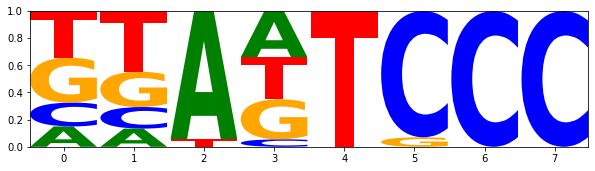

In [9]:
nfkb1_logo = logomaker.Logo(df_nfkb1)

In [10]:
df_rela = read_tf2dna_mat(os.path.join(tf2dna_dir, 'human_tf2dna_matrices_symbols/RELA.mat'))
df_rela

,A,C,G,T
0,0.421,0.198,0.210,0.171
1,0.005,0.265,0.010,0.720
2,0.000,0.000,0.000,1.000
3,0.268,0.207,0.143,0.382
4,0.000,1.000,0.000,0.000
5,0.000,1.000,0.000,0.000
6,0.230,0.409,0.227,0.133
7,0.337,0.142,0.311,0.210


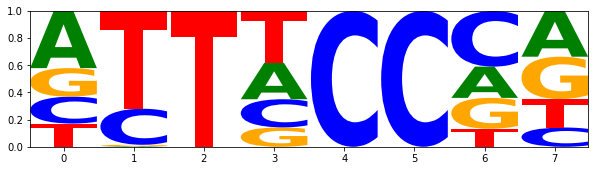

In [11]:
rela_logo = logomaker.Logo(df_rela)

# Gene Targets for NFKB1 and RELA

In [136]:
ensembl = EnsemblRelease(77)

In [139]:
def gene_id_from_name(gene_name):
    try:
        x = ensembl.gene_ids_of_gene_name(gene_name)
    except ValueError:
        return 'unknown_id_{}'.format(gene_name)
    if x is not None and len(x) > 0:
        return x[0]
    return 'unknown_id_{}'.format(gene_name)

def load_pscan_data(gene_name):
    pscan_data = dict()
    for fpath in glob.glob(os.path.join(tf2dna_dir, '**', '{}.pscan'.format(gene_name)),
                           recursive=True):
        root_dir, fname = os.path.split(fpath)
        _, exp_name = os.path.split(root_dir)
        df = pd.read_csv(fpath, sep='\t')
        
        df['target_name_ensembl'] = df['target_name'].map(gene_id_from_name)
        pscan_data[exp_name] = df
    return pscan_data

def reduce_pscan_data(pcsan_data, pval_thresh=1e-5):
    targets = list()
    for df in pscan_data.values():
        i = df['p_value'] < pval_thresh
        targets.extend(df[i]['target_name_ensembl'])
    return np.unique(targets)

In [140]:
pscan_data = load_pscan_data('NFKB1')
nfkb1_targets = reduce_pscan_data(pscan_data)
print('# of target genes for NFKB1: ', len(nfkb1_targets))
nfkb1_targets[:20]

# of target genes for NFKB1:  3042


array(['ENSG00000000938', 'ENSG00000002330', 'ENSG00000002586',
       'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003400',
       'ENSG00000003402', 'ENSG00000004660', 'ENSG00000004809',
       'ENSG00000004864', 'ENSG00000004866', 'ENSG00000004897',
       'ENSG00000005249', 'ENSG00000005339', 'ENSG00000005436',
       'ENSG00000005844', 'ENSG00000005882', 'ENSG00000006047',
       'ENSG00000006059', 'ENSG00000006283'], dtype='<U26')

In [141]:
pscan_data = load_pscan_data('RELA')
rela_targets = reduce_pscan_data(pscan_data)
print('# of target genes for RELA: ', len(rela_targets))
rela_targets[:20]

# of target genes for RELA:  1483


array(['ENSG00000000938', 'ENSG00000002330', 'ENSG00000002586',
       'ENSG00000002587', 'ENSG00000003400', 'ENSG00000004455',
       'ENSG00000004864', 'ENSG00000004866', 'ENSG00000005882',
       'ENSG00000006059', 'ENSG00000006634', 'ENSG00000007080',
       'ENSG00000007350', 'ENSG00000007516', 'ENSG00000007908',
       'ENSG00000008283', 'ENSG00000008323', 'ENSG00000008382',
       'ENSG00000008516', 'ENSG00000008853'], dtype='<U23')

In [148]:
gene_intersect = np.intersect1d(nfkb1_targets, rela_targets)
gene_intersect = [x for x in gene_intersect if not x.startswith('unknown')]
print('# of intersecting genes: ', len(gene_intersect))
out_file = os.path.join(tf_dir, 'nkfb_pscan_genes.txt')
with open(out_file, 'w') as f:
    f.write('\n'.join(gene_intersect))

# of intersecting genes:  1086


In [143]:
nfkb_targets = pd.read_csv(os.path.join(tf_dir, 'nfkb_targets.csv'), header=None, names=['gene'])
nfkb_targets['gene_ensembl'] = nfkb_targets['gene'].map(gene_id_from_name)
nfkb_targets.head()

,gene,gene_ensembl
0,IGHG4,ENSG00000211892
1,IGHG3,ENSG00000211897
2,APOC3,ENSG00000110245
3,TNFRSF6,unknown_id_TNFRSF6
4,CD3G,ENSG00000160654


In [149]:
out_file = os.path.join(tf_dir, 'nfkb_web_genes.txt')
with open(out_file, 'w') as f:
    f.write('\n'.join([x for x in nfkb_targets['gene_ensembl'] if not x.startswith('unknown')]))

# Ontology Analysis

In [150]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo



In [158]:
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2021-05-01) 47,284 GO Terms


In [151]:
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz


In [153]:
human_ncbi_taxonomy_id = 9606
from goatools.anno.genetogo_reader import Gene2GoReader
objanno = Gene2GoReader(fin_gene2go, taxids=[human_ncbi_taxonomy_id])

HMS:0:00:03.723694 341,938 annotations, 20,681 genes, 18,637 GOs, 1 taxids READ: gene2go 


In [155]:
ns2assoc = objanno.get_ns2assc()
for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated genes".format(NS=nspc, N=len(id2gos)))

CC 19,395 annotated genes
BP 18,679 annotated genes
MF 18,180 annotated genes


In [156]:
from genes_ncbi_human_proteincoding import GENEID2NT as GeneID2nt_human
print(len(GeneID2nt_human))

19666


In [159]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), 
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 86% 17,004 of 19,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 91% 17,958 of 19,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 89% 17,476 of 19,666 population items found in association


In [160]:
import mygene
mg = mygene.MyGeneInfo()

In [208]:
gene_info = mg.getgenes(gene_intersect, fields='name,symbol,entrezgene,taxid')
#gene_info = mg.getgenes(nfkb_targets['gene_ensembl'], fields='name,symbol,entrezgene,taxid')

querying 1-1000...done.
querying 1001-1086...done.


In [209]:
df_gene_info = pd.DataFrame(gene_info)

In [210]:
df_gene_info.head()

,query,_id,_version,entrezgene,name,symbol,taxid,notfound
0,ENSG00000000938,2268,2.0,2268,"FGR proto-oncogene, Src family tyrosine kinase",FGR,9606.0,NaN
1,ENSG00000002330,572,4.0,572,BCL2 associated agonist of cell death,BAD,9606.0,NaN
2,ENSG00000002586,4267,2.0,4267,CD99 molecule (Xg blood group),CD99,9606.0,NaN
3,ENSG00000002587,9957,2.0,9957,heparan sulfate-glucosamine 3-sulfotransferase 1,HS3ST1,9606.0,NaN
4,ENSG00000003400,843,2.0,843,caspase 10,CASP10,9606.0,NaN


In [211]:
i = (df_gene_info['notfound'] != True) & ~df_gene_info['entrezgene'].isnull()
print('Identified {} genes out of {}'.format(i.sum(), len(df_gene_info)))
df_gene_info = df_gene_info[i]

Identified 1071 genes out of 1086


In [212]:
#','.join([str(x) for x in df_gene_info['entrezgene'].astype('int')])
print('# of unique:', len(np.unique(df_gene_info['entrezgene'])))

# of unique: 1071


In [213]:
geneid2symbol = {int(row['entrezgene']):row['symbol'] for _,row in df_gene_info.iterrows()}

In [214]:
goea_results_all = goeaobj.run_study(list(df_gene_info['entrezgene'].astype('int')))
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Run BP Gene Ontology Analysis: current study set of 1071 IDs ... 90%    958 of  1,069 study items found in association
100%  1,069 of  1,071 study items found in population(19666)
Calculating 12,362 uncorrected p-values using fisher_scipy_stats
  12,362 GO terms are associated with 17,004 of 19,666 population items
   3,699 GO terms are associated with    958 of  1,071 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      51 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1071 IDs ... 94%  1,007 of  1,069 study items found in association
100%  1,069 of  1,071 study items found in population(19666)
Calculating 1,751 uncorrected p-values using fisher_scipy_stats
   1,751 GO terms are associated with 17,958 of 19,666 population items
     624 GO terms are associated with  1,007 o

In [215]:
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
plot_results("nfkb_{NS}.png", goea_results_sig,
             id2symbol=geneid2symbol, 
             study_items=6,
             items_p_line=3)

    2 usr  25 GOs  WROTE: nfkb_BP.png
    1 usr   5 GOs  WROTE: nfkb_CC.png


# Clinvar SNP analysis

In [271]:
clinvar_file = os.path.join(data_dir, 'clinvar', 'variant_summary.txt')
df_clinvar = pd.read_csv(clinvar_file, sep='\t')
df_clinvar.head()

/home/mschachter/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
0,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704705,...,no assertion criteria provided,1,-,N,"ClinGen:CA215070,OMIM:613653.0001",1,2,4820844,GGAT,TGCTGTAAACTGTAACTGTAAA
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704705,...,no assertion criteria provided,1,-,N,"ClinGen:CA215070,OMIM:613653.0001",1,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
2,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1,3,4827360,GCTGCTGGACCTGCC,G
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1,3,4787729,GCTGCTGGACCTGCC,G
4,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,"Jun 29, 2015",150829393,...,no assertion criteria provided,1,-,N,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O...",1,4,85342440,G,A


In [286]:
i = df_clinvar['Assembly'] == 'GRCh38'
df_clinvar = df_clinvar[i].copy()

In [287]:
i = df_clinvar['GeneSymbol'].isin(['NFKB1', 'RELA']) & \
    (df_clinvar['ClinicalSignificance'] == 'Pathogenic') & \
    (df_clinvar['RS# (dbSNP)'] != -1)
print('Pathogenic SNPs: ', i.sum())
df_snps = df_clinvar[i]
df_snps.head()

Pathogenic SNPs:  16


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
245087,206679,single nucleotide variant,NM_003998.4(NFKB1):c.730+4A>G,4790,NFKB1,HGNC:7794,Pathogenic,1,"Sep 03, 2015",869320688,...,no assertion criteria provided,1,-,N,"ClinGen:CA358854,OMIM:164011.0001",1,210056,102579043,A,G
245089,206680,single nucleotide variant,NM_003998.4(NFKB1):c.835+2T>G,4790,NFKB1,HGNC:7794,Pathogenic,1,"Sep 03, 2015",869320689,...,no assertion criteria provided,1,-,N,"ClinGen:CA358855,OMIM:164011.0002",1,210057,102580641,T,G
245091,206681,Duplication,NM_003998.4(NFKB1):c.465dup (p.Ala156fs),4790,NFKB1,HGNC:7794,Pathogenic,1,"Sep 03, 2015",869320754,...,no assertion criteria provided,1,-,N,"ClinGen:CA357869,OMIM:164011.0003",1,210058,102576931,G,GA
622653,425584,Duplication,NM_003998.4(NFKB1):c.2602_2603dup (p.Thr869fs),4790,NFKB1,HGNC:7794,Pathogenic,1,"Jun 02, 2017",1553938888,...,"criteria provided, single submitter",1,-,N,ClinGen:CA645372757,2,432311,102613430,T,TGG
653202,443533,Deletion,NM_003998.4(NFKB1):c.702del (p.Val235fs),4790,NFKB1,HGNC:7794,Pathogenic,1,"Jul 08, 2017",1553934187,...,"criteria provided, single submitter",1,-,N,ClinGen:CA658657396,2,450428,102579008,AC,A


In [288]:
df_snps.keys()#['Phenotype']

Index(['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID',
       'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)',
       'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList',
       'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession',
       'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele',
       'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines',
       'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID',
       'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF'],
      dtype='object')

In [289]:
df_snps[['GeneSymbol', 'Type']].groupby('Type').count()

,GeneSymbol
Type,
Deletion,6
Duplication,2
single nucleotide variant,8


In [290]:
i = df_snps['GeneSymbol'] == 'NFKB1'
df_snps = df_snps[i].copy()

In [291]:
g = ensembl.genes_by_name('NFKB1')[0]
g

Gene(gene_id='ENSG00000109320', gene_name='NFKB1', biotype='protein_coding', contig='4', start=102501329, end=102617302, strand='+', genome='GRCh38')

In [292]:
g.start

102501329

In [293]:
df_snps[['GeneSymbol', 'Name', 'RS# (dbSNP)', 'Start', 'Stop']]

,GeneSymbol,Name,RS# (dbSNP),Start,Stop
245087,NFKB1,NM_003998.4(NFKB1):c.730+4A>G,869320688,102579043,102579043
245089,NFKB1,NM_003998.4(NFKB1):c.835+2T>G,869320689,102580641,102580641
245091,NFKB1,NM_003998.4(NFKB1):c.465dup (p.Ala156fs),869320754,102576931,102576932
622653,NFKB1,NM_003998.4(NFKB1):c.2602_2603dup (p.Thr869fs),1553938888,102613430,102613431
653202,NFKB1,NM_003998.4(NFKB1):c.702del (p.Val235fs),1553934187,102579009,102579009
653208,NFKB1,NM_003998.4(NFKB1):c.2083G>T (p.Glu695Ter),1553937650,102607278,102607278
1327502,NFKB1,NM_003998.4(NFKB1):c.1071_1074del (p.Glu358fs),1578805410,102593427,102593430
1348452,NFKB1,NM_003998.4(NFKB1):c.260T>G (p.Ile87Ser),1578771120,102566988,102566988
1348454,NFKB1,NM_003998.4(NFKB1):c.293T>A (p.Val98Asp),1578771197,102567021,102567021
1348456,NFKB1,NM_003998.4(NFKB1):c.295C>T (p.Gln99Ter),1578771211,102567023,102567023


In [294]:
# get SNP info
variant_client = get_client('variant')

In [295]:
snp_data = variant_client.querymany(['rs{}'.format(x) for x in df_snps['RS# (dbSNP)']],
                                   scopes='dbsnp.rsid', fields='dbsnp')
snp_data = {d['query'][2:]:d for d in snp_data}

querying 1-15...done.
Finished.
1 input query terms found dup hits:
	[('rs869320689', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


# Combine SNP info with Annotations

In [297]:
nfkb1_seq_file = os.path.join(data_dir, 'sequences/NFKB1/dna/human', 'sequence.fasta')
fasta_sequences = SeqIO.parse(open(nfkb1_seq_file),'fasta')
seq = list(fasta_sequences)[0]
print('# of bases: ', len(seq.seq))

# of bases:  116037


In [298]:
seq

SeqRecord(seq=Seq('TGCGCGCGTGTGTCCGTCTGTCTGTATGCTCTCTCGACGTCAGTGGGAATTTCC...TCA'), id='NC_000004.12:102501266-102617302', name='NC_000004.12:102501266-102617302', description='NC_000004.12:102501266-102617302 Homo sapiens chromosome 4, GRCh38.p13 Primary Assembly', dbxrefs=[])

# of exons in NFKB1:  55


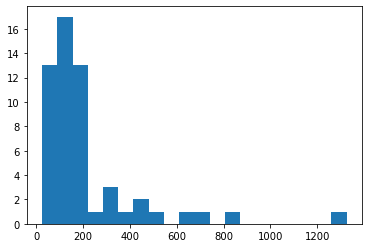

In [299]:
print('# of exons in NFKB1: ', len(g.exons))
exon_lens = [(e.end - e.start) for e in g.exons]
plt.hist(exon_lens, bins=20);

In [302]:
g.exons[0].start

102501329

In [309]:
in_exon = np.zeros(len(df_snps), dtype='bool')
exon_id = np.zeros(len(df_snps))
exon_id[:] = np.nan
exon_length = np.zeros(len(df_snps))
for idx,(row_idx,row) in enumerate(df_snps.iterrows()):
    for k,e in enumerate(g.exons):
        if (row['Start'] <= e.end) and (row['Start'] >= e.start):
            in_exon[idx] = True
            exon_id[idx] = k
            exon_length[idx] = e.end - e.start

In [310]:
df_snps['in_exon'] = in_exon
df_snps['exon_id'] = exon_id
df_snps['exon_length'] = exon_length

In [311]:
df_snps['in_exon'].sum()

13

In [313]:
i = df_snps['in_exon']
df_snps[i][['exon_id', 'exon_length', 'in_exon']].groupby(['exon_id', 'exon_length']).count()

,,in_exon
exon_id,exon_length,
20.0,148.0,3
24.0,163.0,1
30.0,158.0,1
33.0,91.0,1
34.0,138.0,1
37.0,143.0,1
41.0,194.0,1
42.0,141.0,2
45.0,169.0,1


In [314]:
df_snps[i][['GeneSymbol', 'Type']].groupby('Type').count()

,GeneSymbol
Type,
Deletion,6
Duplication,2
single nucleotide variant,5
